In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Dependencies

In [ ]:
!pip install matplotlib

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten

GPU Growth

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
tf.__version__

'2.10.1'

Folder Structure

In [7]:
#setup path

positive_pth = os.path.join('data','pos')
negetive_pth = os.path.join('data','neg')
anchor_pth = os.path.join('data','anchor')


In [ ]:

os.makedirs(positive_pth)
os.makedirs(negetive_pth)
os.makedirs(anchor_pth)

Gathering Data

In [ ]:
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        ex_path = os.path.join('lfw',directory,file)
        new_path = os.path.join(negetive_pth,file)
        os.replace(ex_path,new_path)

Collection Positive and Anchor classes

In [8]:
#Universally Unique identifier is used to generate unique images names
import uuid

In [9]:
uuid.uuid1()

UUID('c95f14a9-8574-11ee-9331-b46bfcf3aa97')

In [10]:
'{}.jpg'.format(uuid.uuid1())

'c9e5d870-8574-11ee-a623-b46bfcf3aa97.jpg'

In [ ]:
#Accessing the webcam
cap = cv2.VideoCapture(0)
while True:
    ret,frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    #collecting positives
    if(cv2.waitKey(1) & 0xff== ord('p')):
        img_name = os.path.join(positive_pth,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name,frame)
        pass

    #collecting anchors
    if(cv2.waitKey(1) & 0xff== ord('a')):
        img_name = os.path.join(anchor_pth,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name,frame)

    cv2.imshow('webcam',frame)
    #closing the webcam using 'q'
    if(cv2.waitKey(1) & 0xff== ord('q')):
        break
cap.release()
cv2.destroyAllWindows()

Data Augmentation # added later for better accuracy

In [11]:
def data_augmentation(img):
    data=[]
    for i in range(9):
        img = tf.image.stateless_random_brightness(img,max_delta=.02,seed=(1,2))
        img = tf.image.stateless_random_contrast(img,lower=.6,upper=1,seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img,seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img,min_jpeg_quality=90,max_jpeg_quality=100,seed=(np.random.randint(100),np.random.randint(100)))
        img=tf.image.stateless_random_saturation(img,lower=.9,upper=1,seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [ ]:
for file in os.listdir(os.path.join(anchor_pth)):
    img_path = os.path.join(anchor_pth,file)
    img=cv2.imread(img_path)
    aug_img = data_augmentation(img)

    for images in aug_img:
        cv2.imwrite(os.path.join(anchor_pth,'{}.jpg'.format(uuid.uuid1())),images.numpy())

In [ ]:
for file in os.listdir(os.path.join(positive_pth)):
    img_path = os.path.join(positive_pth,file)
    img=cv2.imread(img_path)
    aug_img = data_augmentation(img)

    for images in aug_img:
        cv2.imwrite(os.path.join(positive_pth,'{}.jpg'.format(uuid.uuid1())),images.numpy())

Load and Preprocess Images

Get image directories

In [12]:
anchor = tf.data.Dataset.list_files(anchor_pth+'\*.jpg').take(3500)
positive = tf.data.Dataset.list_files(positive_pth+'\*.jpg').take(3500)
negetive = tf.data.Dataset.list_files(negetive_pth+'\*.jpg').take(3500)

#taking 3500 images from each folder

In [13]:
len(anchor)

3500

In [14]:
dir_test = anchor.as_numpy_iterator()
# creating a pipeline

In [15]:
dir_test.next()

b'data\\anchor\\b9ca1587-8535-11ee-a011-b46bfcf3aa97.jpg'

Preprocessing Scaling and resizing

In [16]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)   #  Reading the image
    img = tf.io.decode_jpeg(byte_img)       #  Loading the image
    img = tf.image.resize(img,(100,100))    #  Resizing the image to 100x100x3
    img = img / 255.0                       #  scaling image to be between 0 and 1
    return img

In [ ]:
preprocess('data\\anchor\\d4ab51aa-8535-11ee-a184-b46bfcf3aa97.jpg')

In [ ]:
img = preprocess('data\\anchor\\d4ab51aa-8535-11ee-a184-b46bfcf3aa97.jpg')

In [ ]:
plt.imshow(img)

In [ ]:
img.numpy().max()

In [ ]:
img.numpy().min()

Creating Labelled Dataset

In [17]:
#(anchor,positive) => 1,1,1,1,1
#(anchor,negetive) => 0,0,0,0,0
tf.ones(len(anchor))

<tf.Tensor: shape=(3500,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [18]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(3500,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [19]:
len(anchor)

3500

In [20]:
pos = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
neg = tf.data.Dataset.zip((anchor,negetive,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = pos.concatenate(neg)

In [21]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
sample = data.as_numpy_iterator()

In [23]:
example = sample.next()

Build Train and test partition

In [26]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [27]:
res = preprocess_twin(*example)       # since data is in zip file the * in example here means to extract the files

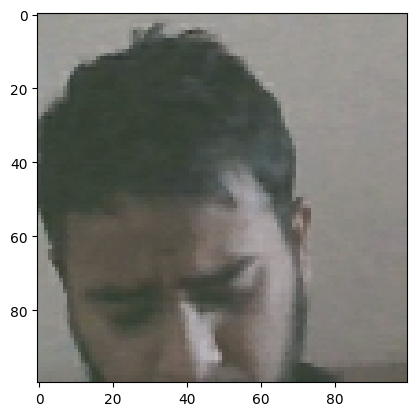

In [28]:
plt.imshow(res[0])

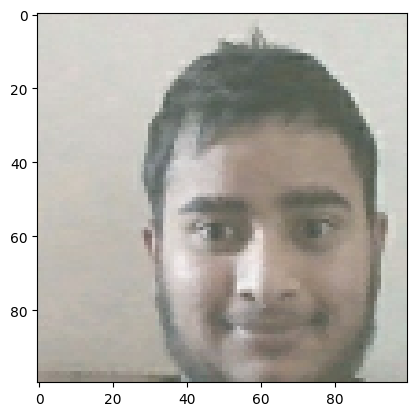

In [29]:
plt.imshow(res[1])

In [30]:
res[2]

1.0

In [31]:
#building dataloader pipeline
data = data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=10000)

In [32]:
samples = data.as_numpy_iterator()
samples.next()

(array([[[0.76960784, 0.76960784, 0.777451  ],
         [0.7742647 , 0.77230394, 0.78112745],
         [0.782598  , 0.7747549 , 0.7865196 ],
         ...,
         [0.16446078, 0.16838235, 0.14485294],
         [0.17083333, 0.1747549 , 0.14534314],
         [0.17941177, 0.18333334, 0.15196079]],
 
        [[0.7737745 , 0.77181375, 0.77867645],
         [0.7764706 , 0.76862746, 0.77843136],
         [0.7794118 , 0.77156866, 0.78137255],
         ...,
         [0.17720588, 0.18112744, 0.15759803],
         [0.1764706 , 0.18039216, 0.1509804 ],
         [0.17941177, 0.18333334, 0.15196079]],
 
        [[0.77181375, 0.7639706 , 0.7678922 ],
         [0.7742647 , 0.76642156, 0.7703431 ],
         [0.7794118 , 0.77156866, 0.7754902 ],
         ...,
         [0.16568628, 0.16960785, 0.14607844],
         [0.16862746, 0.17254902, 0.14313726],
         [0.16568628, 0.16960785, 0.1382353 ]],
 
        ...,
 
        [[0.46666667, 0.39215687, 0.3647059 ],
         [0.4387255 , 0.36617646, 0.33774

In [33]:
samp = samples.next()

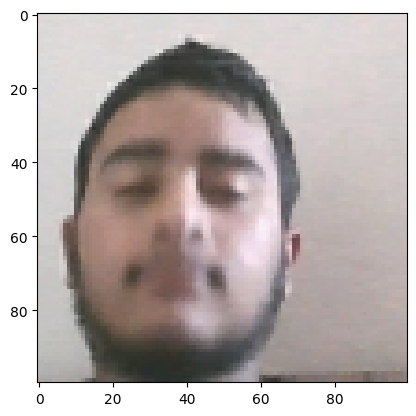

In [34]:
plt.imshow(samp[1])

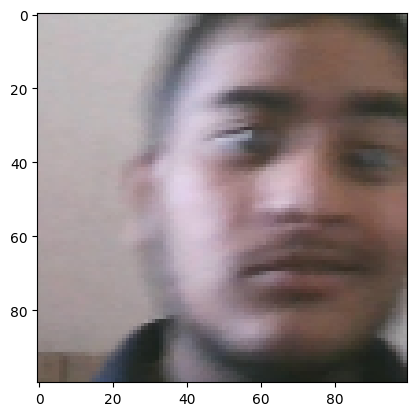

In [35]:
plt.imshow(samp[0])

In [36]:
samp[2]

1.0

In [37]:
round(len(data)*.7)

4900

In [38]:
#creating training partition
train_data = data.take(round(len(data)*.7))     # taking 70% data as training dataset and then rounding off it 
train_data = train_data.batch(16)               # takes batches of 16 images
train_data = train_data.prefetch(8)             # prefetch to increase the speed read more

In [39]:
train_samples = train_data.as_numpy_iterator()

In [40]:
train_sample = train_samples.next()

In [41]:
train_sample

(array([[[[0.71568626, 0.71568626, 0.7078431 ],
          [0.7080882 , 0.72843134, 0.7127451 ],
          [0.7       , 0.7323529 , 0.71960783],
          ...,
          [0.7235294 , 0.7352941 , 0.7       ],
          [0.7294118 , 0.7411765 , 0.7058824 ],
          [0.7294118 , 0.7411765 , 0.7058824 ]],
 
         [[0.7230392 , 0.7294118 , 0.71838236],
          [0.7117647 , 0.7323529 , 0.71666664],
          [0.7007353 , 0.73308825, 0.7203431 ],
          ...,
          [0.73039216, 0.7343137 , 0.7029412 ],
          [0.72745097, 0.73137254, 0.7       ],
          [0.7294118 , 0.73333335, 0.7019608 ]],
 
         [[0.7291667 , 0.7370098 , 0.7252451 ],
          [0.7120098 , 0.73259807, 0.7169118 ],
          [0.7083333 , 0.73406863, 0.7235294 ],
          ...,
          [0.73137254, 0.7352941 , 0.70980394],
          [0.72745097, 0.73137254, 0.7058824 ],
          [0.72745097, 0.73137254, 0.7058824 ]],
 
         ...,
 
         [[0.5882353 , 0.61740196, 0.57598037],
          [0.51617

In [42]:
len(train_sample[0])

16

In [43]:
# validation partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Model Buiding

Building Embedding Layer

In [67]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [68]:
embedding = make_embedding()

In [69]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

Build Distance Layer

In [47]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [48]:
l1=L1Dist()

Make Siamese Model

In [84]:
input_image = Input(name='input_image',shape=(100,100,3))
validation_image = Input(name='validation_image',shape=(100,100,3))

In [85]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [86]:
siamese_layer = L1Dist()

In [87]:
distances = siamese_layer(inp_embedding, val_embedding)

In [88]:
classifier = Dense(1, activation='sigmoid')(distances)

In [90]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [91]:
siamese_network = Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [93]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

In [97]:
def siamese_model():

    # Anchor image input to neural network
    input_image = Input(name="input_img",shape=(100,100,3))
    # Validation image input to neural network
    validation_image = Input(name="validation_img",shape=(100,100,3))

    siamese_layer = L1Dist()
    siamese_layer._name = "distance"    
    distances = siamese_layer(embedding(input_image),embedding(validation_image))

    classifier = Dense(1,activation='sigmoid')(distances)

    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')


In [98]:
model = siamese_model()

In [99]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

Training Siamese Model

Setup Loss and optimizer

In [100]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [101]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Checkpoints

In [103]:
checkpoint_dir = './training_check5'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer,siamese_model=model)

Build Train Step Function

In [104]:
test_batch=train_data.as_numpy_iterator()

In [105]:
batch1 = test_batch.next()

In [106]:
x=batch1[:2]

In [108]:
y=batch1[2]

In [79]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive or negetive image
        X=batch[:2]

        # Get labels
        Y=batch[2]
        yhat = model(X,training=True)

        loss=binary_cross_loss(Y,yhat)
    print(loss)
    #calculate gradients
    grads = tape.gradient(loss,model.trainable_variables)
        
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

    return loss

In [109]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

Train the model

In [110]:
epochs = 50


In [111]:
train(data, epochs)



 Epoch 1/50


ValueError: in user code:

    File "C:\Users\himan\AppData\Local\Temp\ipykernel_9328\2626755191.py", line 9, in train_step  *
        yhat = model(X,training=True)
    File "c:\Users\himan\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\himan\anaconda3\envs\py310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "SiameseNetwork" is incompatible with the layer: expected shape=(None, 100, 100, 3), found shape=(100, 100, 3)


Evaluate Model

Import Metrics

In [65]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

Make Predictions


In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [ ]:
# Make predictions
y_hat = model.predict([test_input, test_val])
y_hat

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
y_true

Calculate Metrics

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

Save Model

In [ ]:
# Save weights
model.save('siameseeeemodelll.h5')

In [ ]:
L1Dist

In [ ]:
# Reload model 
model1 = tf.keras.models.load_model('siameseeeemodel.h5',custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
model1.predict([test_input, test_val])

In [ ]:
# View model summary
model1.summary()

Real Time Test

In [ ]:
os.listdir(os.path.join('application_data', 'verification_image'))


In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        # Make Predictions 
        result = model1.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image'))) 
    verified = verification > verification_threshold
    
    return results, verified

OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
results

In [ ]:
np.squeeze(results)>0.9

In [ ]:
np.sum(np.squeeze(results)>0.9)

In [ ]:
33/50

In [ ]:
!pip install kivy[full] kivy_examples